In [1]:
elastic_rods_dir = '../../../elastic_rods/python/'
weaving_dir = '../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

In [2]:
# Reloadable libraries
import importlib

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, structural_analysis, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(structural_analysis)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

import vis.fields
import matplotlib.cm as cm

In [3]:
import time

In [4]:
# Set to True in the options below if you already optimized a specific linkage
# and you would like to reuse the optimized linkage. Loading is performed in
# place of the full design optimization.
# NOTE: Doesn't seem to work at the moment, leave at False
LOAD_OPTIMIZED_DOFS = False

# Set to False if strips cannot be labeled into families for a model
USE_FAMILY_LABEL = False

In [5]:
rod_length = 0.05979705114046488
width = rod_length / 20 * 5
thickness = width / 5 * 0.35
print(width, thickness)

0.01494926278511622 0.0010464483949581352


In [6]:
# Close Bird
default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
RIBBON_CS = np.around([thickness, width], decimals=5)
MODEL_NAME = "bird_close_beak_1"
MODEL_PATH = osp.join(weaving_dir + 'normalized_objs/models/{}.obj'.format(MODEL_NAME))
SUBDIVISION_RESOLUTION = 20
SMOOTHING_WEIGHT = 10
REGULARIZATION_WEIGHT = 1
INPUT_SURFACE_PATH = osp.join(weaving_dir + 'normalized_objs/surface_models/{}.obj'.format(MODEL_NAME))
RIBBON_NAME = "bird_close_beak_1_strip"

In [7]:
def initialize_linkage(surface_path = INPUT_SURFACE_PATH, useCenterline = True, cross_section = RIBBON_CS, subdivision_res = SUBDIVISION_RESOLUTION, model_path = MODEL_PATH):
    l = elastic_rods.SurfaceAttractedLinkage(surface_path, useCenterline, model_path, subdivision_res, False, InterleavingType.triaxialWeave)
    l.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, cross_section, stiffAxis=elastic_rods.StiffAxis.D1))
    l.setDoFs(l.getDoFs())
    l.set_holdClosestPointsFixed(True);
    l.set_attraction_tgt_joint_weight(0.01);
    l.attraction_weight = 100;
    return l

In [8]:
def initialize_normal_linkage(cross_section = RIBBON_CS, subdivision_res = SUBDIVISION_RESOLUTION, model_path = MODEL_PATH):
    l = elastic_rods.RodLinkage(model_path, subdivision_res, False)
    l.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, cross_section, stiffAxis=elastic_rods.StiffAxis.D1))
    return l

In [9]:
def design_parameter_solve(l,regularization_weight = 0.1, smoothing_weight = 1):
    design_opts = elastic_rods.NewtonOptimizerOptions()
    design_opts.niter = 10000
    design_opts.verbose = 10
    l.set_design_parameter_config(use_restLen = True, use_restKappa = True)
    elastic_rods.designParameter_solve(l, design_opts, regularization_weight = 0.0, smoothing_weight = 0.001)
    l.set_design_parameter_config(use_restLen = True, use_restKappa = True)

In [10]:
def get_linkage_eqm(l, opt, cam_param = default_camera_parameters, target_surf = None):
    elastic_rods.compute_equilibrium(l, options = opt)
    if (target_surf is None):
        view = linkage_vis.LinkageViewer(l, width=1024, height=640)
    else:
        view = linkage_vis.LinkageViewerWithSurface(l, target_surf, width=1024, height=640)
    view.setCameraParams(cam_param)
    return l, view

In [11]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 10;
OPTS.beta = 1e-8
OPTS.niter = 100
OPTS.verboseNonPosDef = False

### Generate straight linkage equilibrium for testing later

In [12]:
# straight_linkage = initialize_linkage(surface_path = INPUT_SURFACE_PATH, useCenterline = True, model_path = MODEL_PATH, cross_section = RIBBON_CS, subdivision_res = SUBDIVISION_RESOLUTION)

In [13]:
# view = linkage_vis.LinkageViewer(straight_linkage, width=1024, height=640)
# view.setCameraParams(default_camera_parameters)
# view.show()

In [14]:
# temp_view = linkage_vis.LinkageViewer(straight_linkage, width=1024, height=640)
# temp_view.setCameraParams(default_camera_parameters)

In [15]:
# temp_view.show()

In [16]:
# export_linkage_geometry_to_obj(straight_linkage, '{}_intialized.obj'.format(MODEL_NAME))

In [17]:
# straight_linkage.attraction_weight = 0
# with so(): straight_linkage, intial_view = get_linkage_eqm(straight_linkage, cam_param = default_camera_parameters, opt = OPTS)
# intial_view.show()

In [18]:
# straight_rod_dof = straight_linkage.getDoFs()

### Create Surface Attracted Linkage and solve for design parameters with fixed joint positions

In [13]:
with so(): curved_linkage = initialize_linkage(surface_path = INPUT_SURFACE_PATH, useCenterline = True, model_path = MODEL_PATH, cross_section = RIBBON_CS, subdivision_res = SUBDIVISION_RESOLUTION)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, INPUT_SURFACE_PATH, width=1024, height=640)
# Optionally configure the visualization colors/transparency
curved_linkage_view.viewOptions[curved_linkage_view.ViewType.LINKAGE].color = 'lightgreen'
curved_linkage_view.viewOptions[curved_linkage_view.ViewType.LINKAGE].transparent = False
curved_linkage_view.viewOptions[curved_linkage_view.ViewType.SURFACE].transparent = True
curved_linkage_view.viewOptions[curved_linkage_view.ViewType.SURFACE].color = 'gray'
curved_linkage_view.applyViewOptions()
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [14]:
# joint_index = 314
# j = curved_linkage.joint(joint_index)
# seg_index = j.segments_A[0]
# vx_index = 0
# if curved_linkage.segment(seg_index).startJoint != joint_index:
#     vx_index = -1
# joint_vector_field = [np.zeros_like(np.reshape(s.rod.gradient()[0:3*s.rod.numVertices()], (s.rod.numVertices(), 3))) for s in curved_linkage.segments()]
# joint_vector_field[seg_index][vx_index] = curved_linkage.segment(seg_index).rod.deformedConfiguration().materialFrame[vx_index].d2
# curved_linkage_view.update()

In [15]:
# get_all_curve_pattern(curved_linkage, RIBBON_CS[1], SUBDIVISION_RESOLUTION, 'test_bird', image_type='svg')

In [16]:
loadedDoFs = np.load("dof_files/{}_0.35mm_0.5mm.npy".format(MODEL_NAME))
curved_linkage.setExtendedDoFs(loadedDoFs)
curved_linkage_view.update()

In [17]:
with so(): elastic_rods.compute_equilibrium(curved_linkage)

In [18]:
curved_linkage_view.update()

In [22]:
# def curved_callback(prob, i):
#     curved_linkage_view.update()

In [23]:
# curved_dpo = elastic_rods.get_designParameter_optimizer(curved_linkage, 0.01, 0.01, callback=curved_callback)
# curved_dpo.options.niter = 1000
# curved_dpp = curved_dpo.get_problem()

In [24]:
# with so(): curved_cr = curved_dpo.optimize()

In [25]:
import linkage_optimization

In [26]:
with so(): elastic_rods.compute_equilibrium(curved_linkage, options = OPTS)

In [27]:
OPTS.niter = 200
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
useCenterline = True
optimizer = linkage_optimization.WeavingOptimization(curved_linkage, INPUT_SURFACE_PATH, useCenterline, equilibrium_options=OPTS, pinJoint = 0, useFixedJoint = False)
optimizer.set_target_joint_position(curved_save_tgt_joint_pos)
# optimizer.setUseCenterline(curved_linkage, useCenterline, 0.01, 10)
curved_linkage_view.update()

In [28]:
optimizer.rl_regularization_weight = 1
optimizer.smoothing_weight = 10
optimizer.beta = 500000.0
optimizer.gamma = 1
algorithm = linkage_optimization.WeavingOptAlgorithm.NEWTON_CG
def update_viewer():
    curved_linkage_view.update()

In [29]:
optimizer.set_holdClosestPointsFixed(True)
optimizer.setLinkageAttractionWeight(1e2)

In [30]:
optimizer.WeavingOptimize(algorithm, 2000, 1.0, 1e-2, update_viewer)

In [30]:
optimizer.set_holdClosestPointsFixed(False)

In [31]:
optimizer.setLinkageAttractionWeight(1e-3)

In [39]:
# if not LOAD_OPTIMIZED_DOFS:
#     optimizer.WeavingOptimize(algorithm, 2000, 1.0, 1e-2, update_viewer)
# else:
#     loadedDoFs = np.load("dof_files/{}.npy".format(MODEL_NAME))
#     linkage.setExtendedDoFs(loadedDoFs)
#     curved_linkage_view.update()

In [40]:
# # Store DoFs to file
# if not os.path.exists("dof_files"):
#     os.makedirs("dof_files")
# rawDoFs = curved_linkage.getExtendedDoFs()
# np.save("dof_files/{}_no_tensile_forces_1e6.npy".format(MODEL_NAME), rawDoFs)

In [41]:
optimizer.WeavingOptimize(algorithm, 2000, 1.0, 1e-2, update_viewer)

In [42]:
curved_optimizer_energy = curved_linkage.energy()
validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
validation_curved_linkage.attraction_weight = 1e-7
with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS)
validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
validation_curved_energy = validation_curved_linkage.energy()
print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

0.0003057773269546913


In [43]:
with so(): elastic_rods.compute_equilibrium(curved_linkage, options = OPTS)

In [110]:
optimizer.objective.terms[-1].term.weight = 1e3
optimizer.objective.terms[-1].term.normalWeight = 1
optimizer.objective.terms[-1].term.tangentialWeight = 1
optimizer.objective.terms[-1].term.boundaryNormalWeight = 0
optimizer.objective.terms[-1].term.boundaryTangentialWeight = 0
optimizer.objective.terms[-1].term.normalActivationThreshold = -1e-4
optimizer.objective.terms[-1].term.value()

0.001486004214049819

In [111]:
optimizer.objective.value()

2.6085429033861254

In [ ]:
optimizer.WeavingOptimize(algorithm, 2000, 1.0, 1e-2, update_viewer)

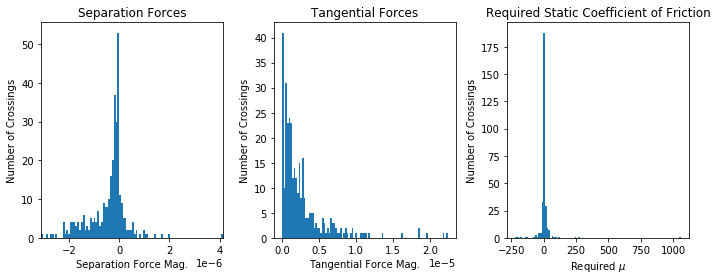

In [46]:
structural_analysis.weavingCrossingAnalysis(validation_curved_linkage, omitBoundary=True)
v = structural_analysis.crossingForceFieldVisualization(validation_curved_linkage, omitBoundary=True)
v.show()

In [39]:
optimizer.objective.terms[-1].term.weight = 1e6
optimizer.objective.terms[-1].term.normalWeight = 1
optimizer.objective.terms[-1].term.tangentialWeight = 1
optimizer.objective.terms[-1].term.boundaryNormalWeight = 0
optimizer.objective.terms[-1].term.boundaryTangentialWeight = 0
optimizer.objective.terms[-1].term.normalActivationThreshold = -1e-4
optimizer.objective.terms[-1].term.value()

1.2766397711537385

In [40]:
optimizer.objective.value()

2.897684995444444

In [41]:
optimizer.WeavingOptimizie(algorithm, 2000, 1.0, 1e-2, update_viewer)

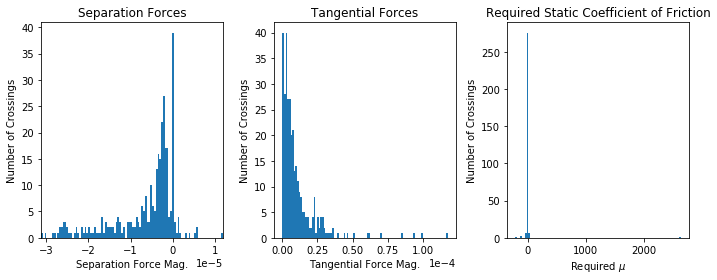

In [37]:
structural_analysis.weavingCrossingAnalysis(curved_linkage, omitBoundary=True)
v2 = structural_analysis.crossingForceFieldVisualization(curved_linkage, omitBoundary=True)
v2.show()

In [51]:
optimizer.objective.value()

2.968305317115149

In [52]:
optimizer.objective.terms[-1].term.weight = 1e8
optimizer.objective.terms[-1].term.normalWeight = 1
optimizer.objective.terms[-1].term.tangentialWeight = 1
optimizer.objective.terms[-1].term.boundaryNormalWeight = 0
optimizer.objective.terms[-1].term.boundaryTangentialWeight = 0
optimizer.objective.terms[-1].term.normalActivationThreshold = -1e-4
optimizer.objective.terms[-1].term.value()

116.60590097273513

In [ ]:
optimizer.WeavingOptimize(algorithm, 2000, 1.0, 1e-2, update_viewer)

In [ ]:
structural_analysis.weavingCrossingAnalysis(curved_linkage, omitBoundary=True)
v3 = structural_analysis.crossingForceFieldVisualization(curved_linkage, omitBoundary=True)
v3.show()

### Apply perturbation 

In [ ]:
# linesearch_weaver = optimizer.get_linesearch_weaver()
# linesearch_weaver.setDoFs(straight_rod_dof)

In [ ]:
# perturbation_test_view = linkage_vis.LinkageViewer(linesearch_weaver, width=1024, height=640)
# perturbation_test_view.setCameraParams(default_camera_parameters)
# perturbation_test_view.show()

In [ ]:
# linesearch_weaver.attraction_weight

In [ ]:
# with so(): elastic_rods.compute_equilibrium(linesearch_weaver, options = OPTS)

In [ ]:
# perturbation_test_view.update()

In [ ]:
# export_linkage_geometry_to_obj(linkage, '{}_optimized.obj'.format(MODEL_NAME))

In [ ]:
# view.getCameraParams()

In [ ]:
# view.setCameraParams(default_camera_parameters)

In [ ]:
# import vis.fields
# import matplotlib.cm as cm
# sf = vis.fields.ScalarField(linkage, 0.5 * np.ones((linkage.numSegments(), linkage.segment(0).rod.numVertices())), colormap=cm.viridis, vmin = 0, vmax = 1)
# view.update(scalarField=sf)
# default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
# view.setCameraParams(default_camera_parameters)

In [32]:
curved_optimizer_energy = curved_linkage.energy()
validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
validation_curved_linkage.attraction_weight = 1e-7
with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS)
validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
validation_curved_energy = validation_curved_linkage.energy()
print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

0.0007529056525952748


In [33]:
validation_curved_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [66]:
# # Store DoFs to file
# if not os.path.exists("dof_files"):
#     os.makedirs("dof_files")
# rawDoFs = validation_curved_linkage.getExtendedDoFs()
# np.save("dof_files/{}_0.35mm_0.5mm.npy".format(MODEL_NAME), rawDoFs)

### Get laser cutting pattern

Min Width  0.01495
num seg per rod 6
num seg per rod 60
num seg per rod 40
num seg per rod 60
num seg per rod 59
num seg per rod 35
num seg per rod 59
num seg per rod 35
num seg per rod 48
num seg per rod 117
num seg per rod 5
num seg per rod 6
num seg per rod 6
num seg per rod 5
num seg per rod 40
num seg per rod 6
num seg per rod 48
[[0, 1, 2, 3, 4, 5, 0], [7, 1, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 29, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 17, 63, 7], [65, 66, 67, 68, 69, 70, 2, 8, 71, 72, 73, 74, 75, 76, 77, 78, 54, 79, 80, 32, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 45, 91, 92, 93, 94, 95, 96, 22, 97, 98, 65], [100, 101, 102, 9, 71, 103, 104, 105, 106, 107, 108, 109, 110, 111, 97, 21, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 33, 81, 123, 124, 125, 126, 127, 128, 129, 130, 90, 44, 131, 132, 133, 134, 135, 136, 137, 119, 138, 13

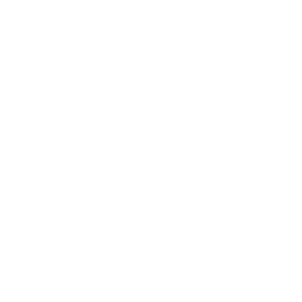

In [43]:
if not os.path.exists(RIBBON_NAME):
    os.makedirs(RIBBON_NAME)
get_all_curve_pattern(validation_curved_linkage, RIBBON_CS[1], SUBDIVISION_RESOLUTION, RIBBON_NAME, image_type='svg', flip_angles = True, target_ribbon_width = 5)

### Generate Output needed by Florin for Rendering

In [36]:
ribbons = order_segments_by_ribbons(validation_curved_linkage)
write_linkage_ribbon_output_florin(validation_curved_linkage, ribbons, SUBDIVISION_RESOLUTION, RIBBON_NAME, False)